In [3]:
from pymongo import MongoClient
import numpy as np

client = MongoClient("mongodb://localhost:27017")
db = client["sentinel_ops_db"]
#collection = db["ms_teams_freezes"]
collection = db["device_crashes"]
# Define the query to filter the documents

filtered_documents = collection.find()

import pandas as pd
data = pd.DataFrame(list(filtered_documents))




# Set the 'timestamp' column as the index of the DataFrame
data.set_index('time_stamp', inplace=True)
# Sort the DataFrame by the index (timestamp) if needed
data.sort_index(inplace=True)

# Group by the date part alone and count the number of crashes per day
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.normalize()
daily_crashes = data.groupby('date').size().reset_index(name='total_crash')
#daily_crashes['date'] = pd.to_datetime(daily_crashes['date'], errors='coerce')
#daily_crashes['total_crash'] = np.asarray(daily_crashes['total_crash'], dtype=np.float64)#pd.to_numeric(daily_crashes['total_crash'], errors='coerce')
daily_crashes.set_index('date', inplace=True)

daily_crashes = daily_crashes.asfreq('D')

# Drop rows with NaN in the specific column
# daily_crashes.dropna(subset=['total_crash'], inplace=True)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


len of train data 96
Post len of train data96


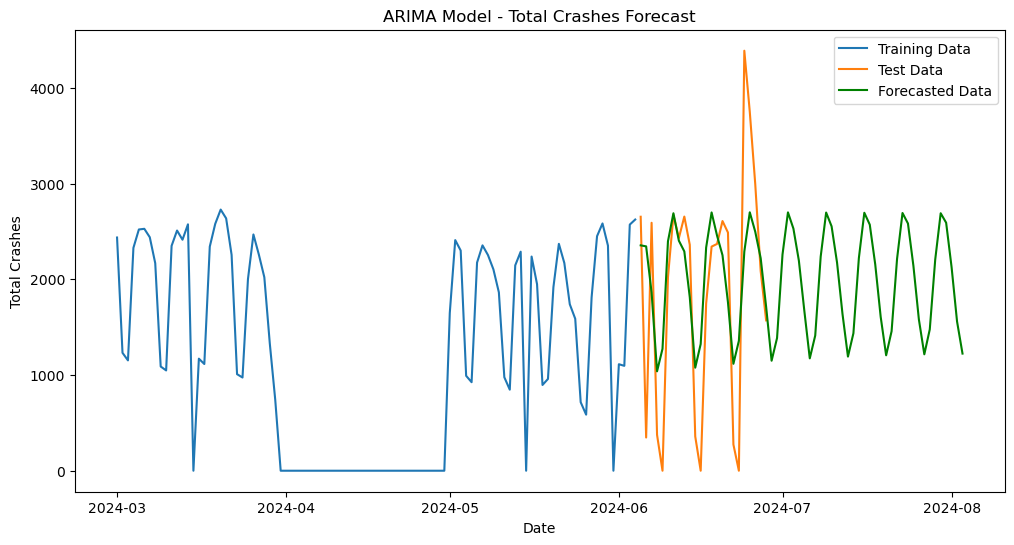

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_data, test_data = train_test_split(daily_crashes, test_size=0.2, shuffle=False)

#train_size = int(len(daily_crashes) * 0.8)
#train_data, test_data = daily_crashes[:train_size], daily_crashes[train_size:]

#time_series = train_data.iloc[:, :]
order=(7, 1, 1)

# np_array = np.asarray(train_data['total_crash'], dtype=np.float64)

model = ARIMA(train_data, order=order)
model_fit = model.fit()

print(f'len of train data {len(train_data)}')
f_row = test_data.iloc[0:1]
#train_data_df = pd.concat([train_data, f_row ], ignore_index=True)

print(f'Post len of train data{len(train_data)}')

#model = ARIMA(daily_crashes, order=order)
#model_fit = model.fit()

forecast = model_fit.forecast(steps=60)
#forecast = pd.Series(forecast, index=test_data.index)

#predictions_list = forecast.to_json(orient='records', date_format='iso') # predictions.iloc[0:steps]#.tolist()
#train_data_list = train_data.to_json(orient='records', date_format='iso') # test_data.iloc[0:steps]#.tolist()
forecast_df = forecast.to_frame()
#print(forecast_df.columns)
        
#Plot graph of training set, Test set and Algorithm prediction on Test set
plt.figure(figsize=(12, 6))
plt.plot(train_data['total_crash'].resample('D').sum(), label='Training Data')
plt.plot(test_data['total_crash'].resample('D').sum(), label='Test Data')
plt.plot(forecast_df['predicted_mean'].resample('D').sum(), label='Forecasted Data', color='green')
#plt.plot(forecast[:1], label='Forecasted Data', color='green')
plt.xlabel('Date')
plt.ylabel('Total Crashes')
plt.title('ARIMA Model - Total Crashes Forecast')
plt.legend()
plt.show()